<a href="https://colab.research.google.com/github/jboca-andes/MIAD_ML_and_NLP/blob/main/S2TC1_RandomForests_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import sys
!{sys.executable} -m conda install --yes py-xgboost

In [10]:
import warnings
warnings.filterwarnings('ignore')
#algo
analisis = {}

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, auc, roc_curve, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold



# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
data.groupby(['HighPrice'])['HighPrice'].count()

HighPrice
0    4406
1    6089
Name: HighPrice, dtype: int64

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [12]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

 # Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [13]:
# Celda 1
tree = tree_grow(X_train, y_train, level=0)
test_pred = tree_predict(X_test, tree, proba=False)
print("F1 score: ", f1_score(y_test, test_pred))
print("Accuracy: ", accuracy_score(y_test, test_pred))
print('Precision:', precision_score(y_test, test_pred))
print('Recall:', recall_score(y_test, test_pred))
analisis["Arbol manual"] = accuracy_score(y_test, test_pred)

F1 score:  0.8824242424242424
Accuracy:  0.8599884526558892
Precision: 0.8670795616960457
Recall: 0.8983218163869694


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [ ]:
y_pred.sum(axis=1)

257343     0
326011     0
242354    10
266376    10
396954    10
          ..
144298     7
364521    10
120072    10
99878      0
387162     0
Length: 3464, dtype: int64

In [ ]:
for filas in y_pred.iterrows():
    print(filas)
    print(sum(filas))
    break

(257343, 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 257343, dtype: int64)
0    257343
1    257343
2    257343
3    257343
4    257343
5    257343
6    257343
7    257343
8    257343
9    257343
Name: 257343, dtype: int64


In [14]:
# Celda 2
np.random.seed(123)
n_samples =  X_train.shape[0]

n_B = 10
samples =  [np.random.choice(a=X_train.index, size=n_samples, replace = True) for _ in range(1, n_B +1)]

# Definición del modelo usando DecisionTreeClassifier de sklearn
tree = DecisionTreeClassifier(random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

tf1 = []
taccu = []
tps = []
trcll= []

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_i = X_train.loc[sample,:]
    y_train_i = y_train[sample]
    tree.fit(X_train_i, y_train_i)
    y_pred.iloc[:,i] = tree.predict(X_test)



for x in range(n_B):
  tf1.append(f1_score(y_test, y_pred.iloc[:,x]))
  taccu.append(accuracy_score(y_test, y_pred.iloc[:,x]))
  tps.append(precision_score(y_test, y_pred.iloc[:,x]))
  trcll.append(recall_score(y_test, y_pred.iloc[:,x]))



print("F1 score: ", sum(tf1)/n_B)
print("Accuracy: ", sum(taccu)/n_B)
print('Precision:', sum(tps)/n_B)
print('Recall:', sum(trcll)/n_B)
analisis["Bagging manual"] = sum(taccu)/n_B

F1 score:  0.857984046186591
Accuracy:  0.8342956120092377
Precision: 0.8601186922704077
Recall: 0.8559230009871668


#### Comentarios sobre el desempeño del modelo
Posterior a la generación del modelo utilizando un solo arbol versus la ejecución del bagging manual con 10 arboles de decisión, se puede evidenciar una disminución en la capacidad de predicción, esto no solamente al evaluar el accuracy sino comprobando dicha afirmación con el Recall. Sin embargo, estos cambios, aunque no son sustanciales, pueden indicar un pequeño sobre ajuste en el arbol manual creado originalmente, esto se debe a que al utilizar multiples arboles para la realización de la predicción, estamos reduciendo la posibilidad de presentar sobre ajuste al modelo.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [15]:
# Celda 3


baglib = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                          max_features=int(np.log(len(X_train.columns))),bootstrap=True, 
                          oob_score=True, random_state=1)
baglib.fit(X_train, y_train)
y_pred = baglib.predict(X_test)

print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

analisis["Bagging libreria"] = accuracy_score(y_test, y_pred)


F1 score:  0.8791666666666667
Accuracy:  0.8493071593533488
Precision: 0.8278116826503923
Recall: 0.937314906219151


#### Comentarios sobre el desempeño del modelo

Posterior a la verificación realizada en el punto 2, en donde se realizó un bagging manual con 10 arboles de decisión, se realiza el mismo procedimiento utilizando las librerias disponibles, aunque en este proceso se evidencia una mejora en el Recall, cabe anotar que el dataset está balanceado y la clase positiva en este caso corresponde a la clase con mayor cantidad de datos, lo que nos permite utilizar metricas como accuracy o precision para evaluar correctamente el desempeño del modelo que para este caso, no implican cambios sustanciales respecto al desempeño del modelo.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [16]:
# Celda 4
rfc =  RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

analisis["RandomForest libreria"] = accuracy_score(y_test, y_pred)

F1 score:  0.8668471572729511
Accuracy:  0.8438221709006929
Precision: 0.8645066273932254
Recall: 0.8692003948667325


#### Comentarios sobre el desempeño del modelo

Cabe resaltar que RandomForest es la evolución del modelo original de Bagging (Utilizado previamente), esto nos lleva a pensar que en muchos casos vamos a tener mejoras, sin embargo, en escenarios como el planteado en este taller, no se logra evidenciar dicha mejora, esto se debe a que RandomForest demuestra un mejor desempeño principalmente en escenarios desbalanceados (Diferente al escenario aquí planteado), y aunque se ven cambios muy pequeños en metricas como la precision o el Recall, estos cambios no son significativos como para poder concluir que un modelo sea mejor que el otro.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [19]:
feature_cols = data.columns[0:9]

In [ ]:
# Celda 5 
estimator_range= range(10,310,10)
accuracy_scores= []
RMSE_scores = []
MSE_scores = []
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators =estimator, random_state=1, n_jobs=-1 )
    accuracy_scores.append(cross_val_score(clf,X, y, cv=5, scoring='accuracy').mean())
    MSE_scores = cross_val_score(clf,X,y, cv=5, scoring='neg_mean_squared_error' )
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0, 0.5, 'Accuracy')

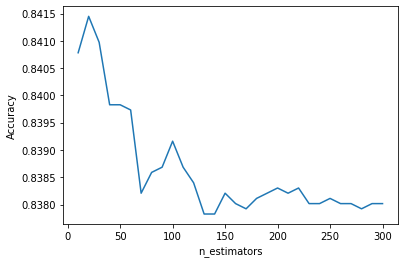

In [ ]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

#### Comentarios sobre el parametro **n_estimators**

Al realizar diversas pruebas variando dicho parametro, se evidencia que el aumento significativo de arboles en modelo, no mejora su desempeño, y por el contrario tiende a afectarlo, cabe resaltar que las escalas demuestran que dicha afectación no es significativa, manteniendo un *Accuracy* promedio de 0.83975, con un *Maximo* de 0.8415 y un *Minimo* de 0.8380, que nos da variacion de solo +/- 0.00175


Text(0, 0.5, 'RMSE')

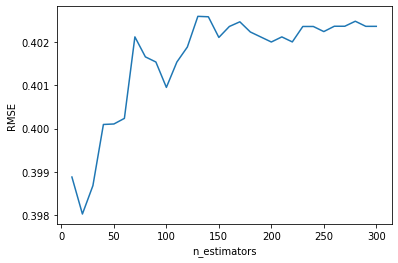

In [ ]:
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [ ]:
error, n_estimators = sorted(zip(RMSE_scores, estimator_range))[0]
(error, n_estimators)                                                          

(0.39802489654962725, 20)

Text(0, 0.5, 'Accuracy')

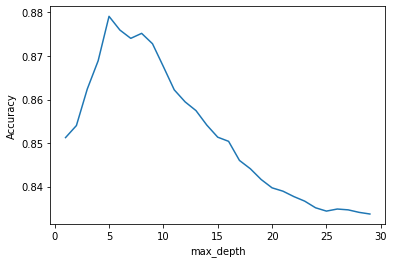

In [ ]:
max_depth_range = range(1, 30)
accuracy_scores = []
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [ ]:
feature_range = range(1, len(feature_cols)+1)
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []
# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

In [ ]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.851357789423535, 9)

#### Comentarios sobre el parametro **max_depth**

Al realizar un proceso de verificación del desempeño del modelo variando los valores del parametro *max_depth*, se evidencia una mejora significativa al aumentar dicho valor, sin embargo, después de un punto (5) podemos ver que dicho desempeño se afecta notablemente, para este caso particular, se recomienda dejar la profundidad de los arboles en 5 con el objetivo de maximizar la capacidadd de predicción de los mismos.

Text(0, 0.5, 'Accuracy')

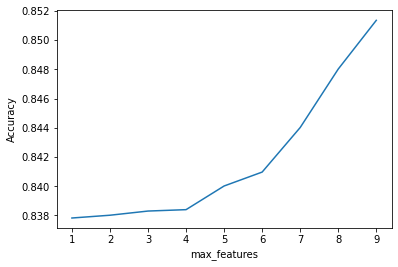

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [20]:
#Se coloca al observar que el estimador optimo es 20 dentro del clasificador
clf = RandomForestClassifier(n_estimators=20, max_features=9, max_depth=5, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')
y_predrm = clf.predict(X_test)
print("F1 score: ", f1_score(y_test, y_predrm))
print("Accuracy: ", accuracy_score(y_test, y_predrm))
print('Precision:', precision_score(y_test, y_predrm))
print('Recall:', recall_score(y_test, y_predrm))

F1 score:  0.9081364829396326
Accuracy:  0.8888568129330254
Precision: 0.8789838337182448
Recall: 0.93928923988154


In [21]:
analisis["RandomForest Optimización"] = accuracy_score(y_test, y_predrm)

#### Comentarios sobre el parametro **max_features**

Al evaluar el parametro *max_features* se logra evidenciar una mejora en el desempeño del clasificador, esto demuestra que al considerar una mayor cantidad de variables predictoras en cada uno de los splits de los arboles, estos mejoran su capacidad de prediccion de forma directa.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [22]:
# Celda 6
clf = XGBClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

F1 score:  0.9070045421945971
Accuracy:  0.8877020785219399
Precision: 0.8794622160407974
Recall: 0.9363277393879565


In [23]:
analisis["XGB predeterminado"] = accuracy_score(y_test, y_pred)

#### Comentarios sobre XGBoost

Aunque logramos evidenciar una mejora significativa al comparar XGBoost vs las primeras implementaciones en este taller, es de resaltar que los arboles de decision ensamblados logran un desempeño similar al realizar un proceso de optimziación de sus hiperparametros, esto genera una ventaja importante al considerar que afinar los hiperparametros de los arboles de decision, puede considerarse mas sencillo que calibrar dichos elementos en XGBoost, cabe anotar que para las particularidades de este problema, no es posible concluir que un modelo se comporte mejor que el otro en terminos de desempeño.


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [ ]:
# Celda 7
kfold = StratifiedKFold(n_splits=10, shuffle=True)
learning_rate = [0.00001, 0.00005,  0.0001, 0.0005,  0.001, 0.005, 0.01, 0.05, 0.08, 0.1, 0.15, 0.18, 0.2, 0.3, 0.4, 0.5, 0.6]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
   print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.271114 using {'learning_rate': 0.1}
-0.692537 (0.000011) with: {'learning_rate': 1e-05}
-0.690111 (0.000055) with: {'learning_rate': 5e-05}
-0.687102 (0.000111) with: {'learning_rate': 0.0001}
-0.664081 (0.000547) with: {'learning_rate': 0.0005}
-0.637699 (0.001051) with: {'learning_rate': 0.001}
-0.491243 (0.004547) with: {'learning_rate': 0.005}
-0.396527 (0.007836) with: {'learning_rate': 0.01}
-0.275137 (0.015135) with: {'learning_rate': 0.05}
-0.271509 (0.016429) with: {'learning_rate': 0.08}
-0.271114 (0.016577) with: {'learning_rate': 0.1}
-0.272008 (0.017278) with: {'learning_rate': 0.15}
-0.272013 (0.017293) with: {'learning_rate': 0.18}
-0.273146 (0.017478) with: {'learning_rate': 0.2}
-0.276192 (0.019745) with: {'learning_rate': 0.3}
-0.279161 (0.019740) with: {'learning_rate': 0.4}
-0.283541 (0.020274) with: {'learning_rate': 0.5}
-0.285984 (0.022509) with: {'learning_rate': 0.6}


In [6]:
modelo2 =  XGBClassifier(learning_rate=0.1)
modelo2.fit(X_train, y_train)
ypredic2 = modelo2.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8877020785219399


#### Comentarios sobre el parametro **learning_rate**

Posterior a la evaluación de dicho parametro y aunque el proceso de optimización señala que 0.1 permite mejorar el desempeño del modelo, el comportamiento del mismo es muy similar al comportamiento logrado de forma automatica.

In [ ]:
# Celda 7
kfold = StratifiedKFold(n_splits=10, shuffle=True)
gamma = [0.00001, 0.00005,  0.0001, 0.0005,  0.001, 0.005, 0.01, 0.05, 0.1,  0.2, 0.3, 0.4, 0.5, 0.6, 1, 2, 10, 100, 1000]
param_grid = dict(gamma=gamma)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
   print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.271002 using {'gamma': 0.1}
-0.271114 (0.016577) with: {'gamma': 1e-05}
-0.271114 (0.016577) with: {'gamma': 5e-05}
-0.271114 (0.016577) with: {'gamma': 0.0001}
-0.271114 (0.016577) with: {'gamma': 0.0005}
-0.271114 (0.016577) with: {'gamma': 0.001}
-0.271077 (0.016509) with: {'gamma': 0.005}
-0.271128 (0.016537) with: {'gamma': 0.01}
-0.271173 (0.016714) with: {'gamma': 0.05}
-0.271002 (0.016606) with: {'gamma': 0.1}
-0.271142 (0.016724) with: {'gamma': 0.2}
-0.271107 (0.016666) with: {'gamma': 0.3}
-0.271182 (0.016872) with: {'gamma': 0.4}
-0.271148 (0.016619) with: {'gamma': 0.5}
-0.271006 (0.016790) with: {'gamma': 0.6}
-0.271061 (0.016884) with: {'gamma': 1}
-0.271120 (0.016474) with: {'gamma': 2}
-0.274556 (0.015675) with: {'gamma': 10}
-0.306972 (0.014123) with: {'gamma': 100}
-0.410334 (0.008086) with: {'gamma': 1000}


In [8]:
modelo2 =  XGBClassifier(gamma=0.1)
modelo2.fit(X_train, y_train)
ypredic2 = modelo2.predict(X_test)
print(accuracy_score(y_test, ypredic2))

0.8877020785219399


#### Comentarios sobre el parametro **gamma**

Al igual que lo ocurrido con el parametro *learning_rate* no se logra evidenciar una mejora en el desempeño del modelo a traves de la optimizacion de dicho hiperparametro, logrando los mismos valores sobre la metrica *accuracy*

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
colsample_bytree = [0.00001, 0.00005,  0.0001, 0.0005,  0.001, 0.005, 0.01, 0.05, 0.1,  0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.98, 1]
param_grid = dict(colsample_bytree=colsample_bytree)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]

for mean, stdev, param in zip(means, stds, params):

   print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.271028 using {'colsample_bytree': 0.9}
-0.287633 (0.014919) with: {'colsample_bytree': 1e-05}
-0.287633 (0.014919) with: {'colsample_bytree': 5e-05}
-0.287633 (0.014919) with: {'colsample_bytree': 0.0001}
-0.287633 (0.014919) with: {'colsample_bytree': 0.0005}
-0.287633 (0.014919) with: {'colsample_bytree': 0.001}
-0.287633 (0.014919) with: {'colsample_bytree': 0.005}
-0.287633 (0.014919) with: {'colsample_bytree': 0.01}
-0.287633 (0.014919) with: {'colsample_bytree': 0.05}
-0.287633 (0.014919) with: {'colsample_bytree': 0.1}
-0.287633 (0.014919) with: {'colsample_bytree': 0.2}
-0.274871 (0.015892) with: {'colsample_bytree': 0.3}
-0.272462 (0.016129) with: {'colsample_bytree': 0.4}
-0.271366 (0.016578) with: {'colsample_bytree': 0.5}
-0.271297 (0.016402) with: {'colsample_bytree': 0.6}
-0.271088 (0.016063) with: {'colsample_bytree': 0.7}
-0.271295 (0.016403) with: {'colsample_bytree': 0.8}
-0.271028 (0.016600) with: {'colsample_bytree': 0.9}
-0.271028 (0.016600) with: {'colsam

In [9]:
modelofinal =  XGBClassifier(colsample_bytree= 0.9)
modelofinal.fit(X_train, y_train)
ypredicfinal = modelofinal.predict(X_test)
print(accuracy_score(y_test, ypredicfinal))

0.8877020785219399


In [24]:
modelofinal =  XGBClassifier(gamma=0.1, learning_rate=0.1, colsample_bytree= 0.9)
modelofinal.fit(X_train, y_train)
ypredicfinal = modelofinal.predict(X_test)
print(accuracy_score(y_test, ypredicfinal))
analisis["XGB Optimizado"] = accuracy_score(y_test, ypredicfinal)

0.8874133949191686


#### Comentarios sobre el parametro **colsample_bytree**

Al igual que lo ocurrido con los 2 parametros anteriormente evaluados, no se logra obtener una mejora o un cambio significativo al intentar optimizar dichos hiperparametros de forma independiente, cabe anotar que es posible que las variaciones en la combinacion de estos parametros en el modelo permitan tener mejoras en el desempeño del mismo, sin embargo, al evaluarlos uno a uno y de forma independiente, no se logra obtener un cambio sobre la metrica evaluada.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

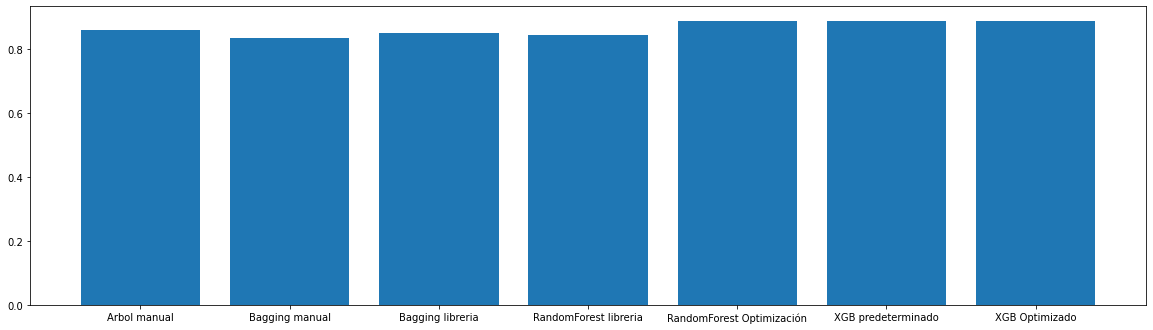

In [29]:
# Celda 8
names = list(analisis.keys())
values = list(analisis.values())
plt.bar(range(len(analisis)), values, tick_label=names)
plt.rcParams["figure.figsize"] = (20,40)
plt.show()

In [31]:
pd.DataFrame([analisis])

,Arbol manual,Bagging manual,Bagging libreria,RandomForest libreria,RandomForest Optimización,XGB predeterminado,XGB Optimizado
0,0.859988,0.834296,0.849307,0.843822,0.888857,0.887702,0.887413


#### Comparación de los modelos

Como se puede evidenciar en la grafica previamente presentada, los modelos no tienen variaciones muy significativas entre si, el modelo con el menor desempeño es el Bagging Manual, sin embargo, cabe resaltar que aunque el bagging busca mejorar el desempeño del accuracy, tambien reduce la posibilidad de tener un sobre ajuste en las predicciones.

Por otra parte, logramos evidenciar que el modelo con mejor desempeño es el RandomForest posterior a la optimización de sus hiperparametros.

Ahora bien, comparando exclusivamente el *RandomForest* y el *XGBoost*, se logra evidenciar que el XGBoost tiene un mejor desempeño sobre el RandomForest sin la necesidad de realizar un proceso de optimización de hiperparametros, sin embargo, esto cambia cuando optimizamos dichos parametros en los diferentes escenarios, logrando mejorar el desempeño en el RandomForest y manteniendolo muy estable en el XGBoost.